[*********************100%%**********************]  1 of 1 completed


OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  Clo

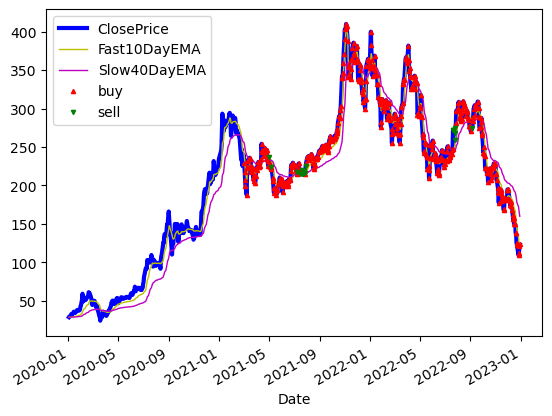

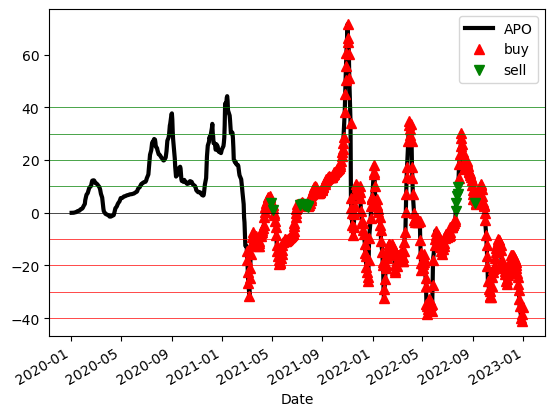

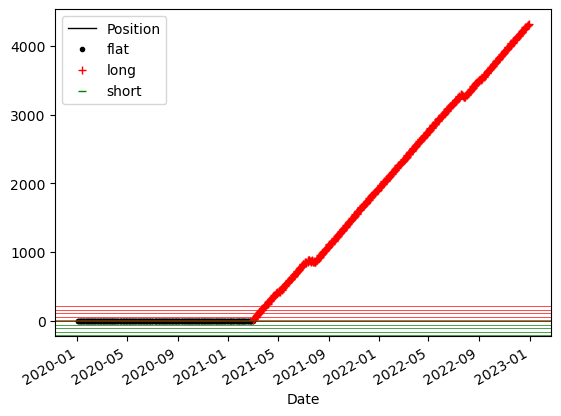

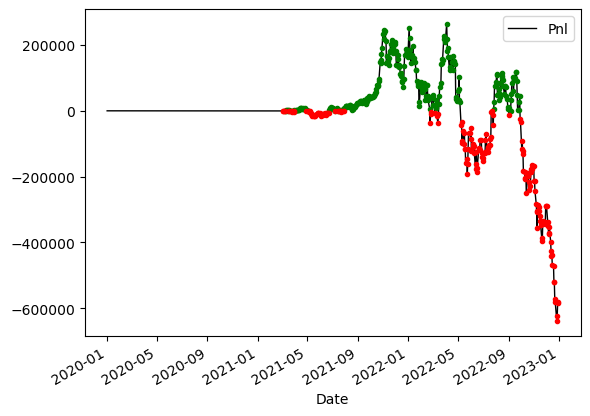

In [28]:
import pandas as pd
import yfinance as yf
import statistics as stats
import math
import matplotlib.pyplot as plt

# Fetch daily data for 4 years
SYMBOL = 'TSLA'
start_date = '2020-01-01'
end_date = '2023-01-01'

data = yf.download(SYMBOL, start_date, end_date)

# EMO 계산을 위한 변수/상수
NUM_PERIODS_FAST = 10
K_FAST = 2 / (NUM_PERIODS_FAST + 1)
ema_fast = 0
ema_fast_values = []

NUM_PERIODS_SLOW = 40
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)
ema_slow = 0
ema_slow_values = []

apo_values = []

# 전략 트레이딩 전략과 포지션 및 Pnl관리를 정의/통제하는 변수가 필요함
orders = []
positions = []
pnls = []

last_buy_price = 0
last_sell_price = 0
position = 0
buy_sum_price_qty = 0
buy_sum_qty = 0
sell_sum_price_qty = 0
sell_sum_qty = 0
open_pnl = 0
closed_pnl = 0

# 진입 임계값, 마지막 거래 이후의 최소 가격변동, 거래당 예상되는 최소 이익 및 거래당 거래할 주식 수 명확히 정의
APO_VALUE_FOR_BUY_ENTRY = -10
APO_VALUE_FOR_SELL_ENTRY = 10
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
NUM_SHARES_PER_TRADE = 10
MIN_PROFIT_TO_CLOSE = 10 * NUM_SHARES_PER_TRADE

# Constants/variables that are used to compute standard deviation as a volatility measur
SMA_NUM_PERIODS = 20
price_history = []

close = data['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS:
        del price_history[0]

    sma = stats.mean(price_history)
    variance = sum((hist_price - sma) ** 2 for hist_price in price_history)
    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev / 15
    if stdev_factor == 0:
        stdev_factor = 1

    if ema_fast == 0:
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST * stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW * stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # 매수/매도 조건 체크 및 실행
    if ((apo < APO_VALUE_FOR_BUY_ENTRY * stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)
            or (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor))):
        orders.append(+1)
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE
        buy_sum_price_qty += close_price * NUM_SHARES_PER_TRADE
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    elif position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor):
        orders.append(-1)
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE
        sell_sum_price_qty += close_price * NUM_SHARES_PER_TRADE
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    else:
        orders.append(0)

    positions.append(position)

    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0:
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position == 0:
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
    pnls.append(closed_pnl + open_pnl)

data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[data.Trades == 1].index, data.ClosePrice[data.Trades == 1], color='r', lw=0, marker='^', markersize=3, label='buy')
plt.plot(data.loc[data.Trades == -1].index, data.ClosePrice[data.Trades == -1], color='g', lw=0, marker='v', markersize=3, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

data.to_csv("volatility_adjusted_trend_following.csv", sep=",")


[*********************100%%**********************]  1 of 1 completed


OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 TotalPnL: 0
OpenPnL: 0 ClosedPnL: 0 Tota

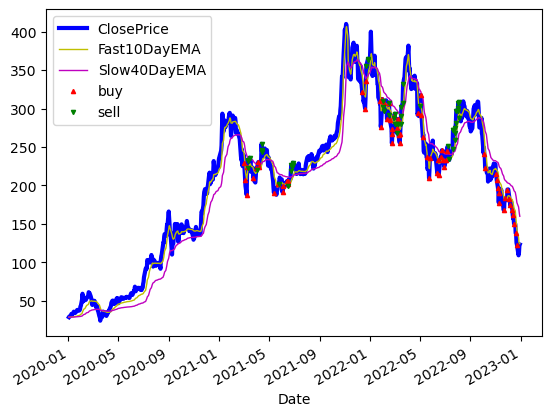

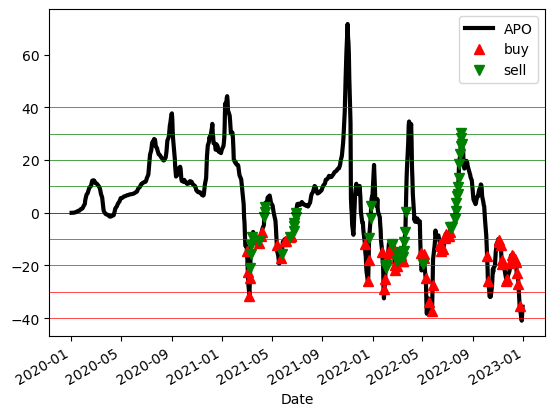

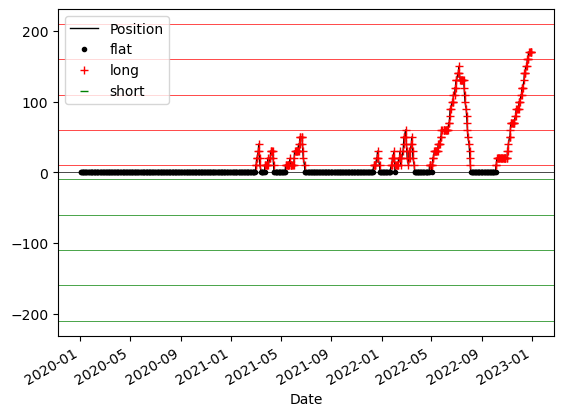

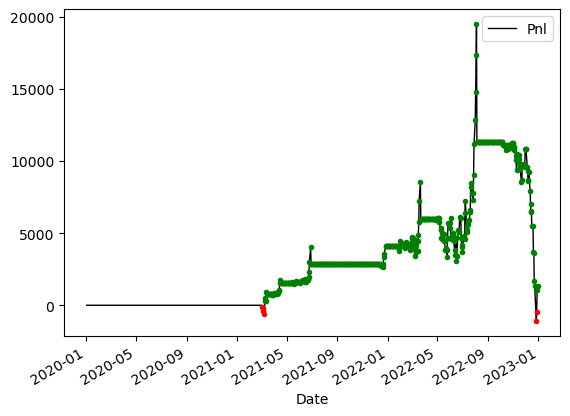

In [37]:
#위 전략에서 매도는 position이 0 이상일 떄만 시행가능하게 하여서 short 차단

import pandas as pd
import yfinance as yf
import statistics as stats
import math

# 데이터 가져오기
SYMBOL = 'TSLA'
start_date = '2020-01-01'
end_date = '2023-01-01'
data = yf.download(SYMBOL, start_date, end_date)

# EMA 계산을 위한 초기 변수 설정
NUM_PERIODS_FAST = 10
K_FAST = 2 / (NUM_PERIODS_FAST + 1)
ema_fast = 0
ema_fast_values = []

NUM_PERIODS_SLOW = 40
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)
ema_slow = 0
ema_slow_values = []

apo_values = []

orders = []
positions = []
pnls = []

last_buy_price = 0
last_sell_price = 0
position = 0
buy_sum_price_qty = 0
buy_sum_qty = 0
sell_sum_price_qty = 0
sell_sum_qty = 0
open_pnl = 0
closed_pnl = 0

APO_VALUE_FOR_BUY_ENTRY = -10
APO_VALUE_FOR_SELL_ENTRY = 10
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
NUM_SHARES_PER_TRADE = 10
MIN_PROFIT_TO_CLOSE = 10 * NUM_SHARES_PER_TRADE

SMA_NUM_PERIODS = 20
price_history = []

close = data['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS:
        del price_history[0]

    sma = stats.mean(price_history)
    variance = sum((hist_price - sma) ** 2 for hist_price in price_history)
    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev / 15 if stdev / 15 > 0 else 1

    # EMA 업데이트
    ema_fast = close_price if ema_fast == 0 else (close_price - ema_fast) * K_FAST * stdev_factor + ema_fast
    ema_slow = close_price if ema_slow == 0 else (close_price - ema_slow) * K_SLOW * stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # 매도 조건
    if position > 0 and ((apo > APO_VALUE_FOR_SELL_ENTRY * stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor) or
                         (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)):
        orders.append(-1)
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE
        sell_sum_price_qty += close_price * NUM_SHARES_PER_TRADE
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print("Sell", NUM_SHARES_PER_TRADE, "@", close_price, "Position:", position)

    # 매수 조건
    elif apo < APO_VALUE_FOR_BUY_ENTRY * stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor:
        orders.append(1)
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE
        buy_sum_price_qty += close_price * NUM_SHARES_PER_TRADE
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print("Buy", NUM_SHARES_PER_TRADE, "@", close_price, "Position:", position)

    else:
        orders.append(0)

    positions.append(position)

    # 손익 계산
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0:
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
    else:
        closed_pnl += sell_sum_price_qty - buy_sum_price_qty
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print("OpenPnL:", open_pnl, "ClosedPnL:", closed_pnl, "TotalPnL:", open_pnl + closed_pnl)
    pnls.append(open_pnl + closed_pnl)

# 데이터 프레임 준비 및 시각화
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[data.Trades == 1].index, data.ClosePrice[data.Trades == 1], color='r', lw=0, marker='^', markersize=3, label='buy')
plt.plot(data.loc[data.Trades == -1].index, data.ClosePrice[data.Trades == -1], color='g', lw=0, marker='v', markersize=3, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()
data.to_csv("volatility_adjusted_mean_reversion.csv", sep=",")
